This experiment compares a number of log statistics presented in Jones et al., Lucchess et al., and Hagen et al.

# Setup

In [1284]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import numpy as np
import itertools
import urllib
import sys
sys.path.append('../variables/')
import UserActivity
import matplotlib
import matplotlib.pylab as pylab
from bson.objectid import ObjectId
from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu

font = {'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2

# DB connections
client = MongoClient()
db = client.db_tasklog_clean
# Collections
User = db.user
Log = db.log_chrome
Labelled = db.data_labeled
UserTasks = db.user_tasks

# Tasks to be excluded
to_exclude = ['000', '001', '002', '003', '004']
# Pre-defined labels - excluding "not sure (001)"
pre_tasks = ['001', '002', '003', '004']
# new query 
query_events = ['tab-search-new', 'tab-search-verticle'] 
# Get user task activities
# Set dummy parameters
t_thresh = -1 # Look at first X minutes, not used
session_thresh = 30 # in minutes, threshold to consider users have left without closing the tab, not used
to_include = [] # Not used for this computation 

## Effective size for M-U test

In [1312]:
def ef_MU(sample1, sample2, h="two-sided"):
    total_pairs = len(sample1) * len(sample2)
    support = 0
    for pair in itertools.product(sample1, sample2):
        diff = pair[0] - pair[1] 
        if h == 'less' and diff < 0:
            support += 1
        elif h == 'greater' and diff > 0:
            support += 1
        else:
            if diff == 0:
                support += 1
    return float(support)/total_pairs


0.4444444444444444

## Function to get all events for a user

In [1285]:
# All events
def event_stream(data):
    events = []
    # data consists of tab-groups
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        # tab groups consist of url groups
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            for e in url_group:
                events.append(e)
    events.sort(key=lambda x: x['timestamp_bson'])
    return events

## Prepare user activity data for analysis

In [1286]:
# Gether user activity data for analysis
UA = []
users = list(User.find({}))
for u in users:
    userid = u['userid']
    data = list(Labelled.find({'userid': u['userid']}))[0]['data']
    events = event_stream(data)
    ua = UserActivity.UserActivity(data, to_include, t_thresh, session_thresh)
    a_path, a_stream = ua.get_user_path()
    
    # filter out events where user was not on the tab
    user_stream = list(itertools.ifilter(lambda x: x[1] == True, a_stream))
    UA.append((userid, user_stream))

## Functions to filter event or task types

In [1287]:
# Data format: stream of events
# All tasks except those are labelled as "None"
def filter_tasks(data):
    return list(itertools.ifilter(lambda x: not x[0]['taskid'] == 'None', data))

def filter_user_tasks(data):
    return list(itertools.ifilter(lambda x: not x[0]['taskid'] in (['None'] + to_exclude), data))

def filter_predefined_tasks(data):
    return list(itertools.ifilter(lambda x: x[0]['taskid'] in pre_tasks, data))

def filter_query_events(data):
    return list(itertools.ifilter(lambda x: x[0]['event'] in query_events, data))

## Function to compute time gap between events

In [1288]:
# Data format: stream of events
# It still contains the "on" value, but we don't use it, as the data is already filtered on events where users are on
def time_gap(data):
    G = []
    start = -1
    i = 0
    for event, on in data:
        event['dwell'] = -1
        if start == -1:
            start = event['timestamp_bson']
            continue
        gap = (event['timestamp_bson'] - start).total_seconds()/60
        # Follow Hagen, if idle for 90 mins, assume user has left
        if gap < 90:
            data[i][0]['dwell'] = gap
        start = event['timestamp_bson']
        i += 1
    return data

## Function to create logical sessions

In [1289]:
# Criteria for logical session:
# 1. consecutive events belong to the same task
# 2. a pause longer than 90 mins makes a session break (user may have left)
# Data format: stream of events
# Data should have already been filtered to only include event where the user is "on"
def logical_session(data):
    L = []
    s = []
    prev = -1
    for event, on in data:
        if prev == -1:
            prev = event
            s.append(event)
            continue
        gap = (event['timestamp_bson'] - prev['timestamp_bson']).total_seconds()/60
        # Keep adding to the logical session if conditions are satisfied
        if prev['taskid'] == event['taskid'] and gap < 90:
            s.append(event)
        # Otherwise, start a new session
        else:
            slength = (s[-1]['timestamp_bson'] - s[0]['timestamp_bson']).total_seconds()
            # Filter out sessions that last 0 seconds
            if not s == [] and slength > 0:
                L.append(s)
            s = []
            s.append(event)
        prev = event
    # Add the last session
    slength = (s[-1]['timestamp_bson'] - s[0]['timestamp_bson']).total_seconds()
    if not s == [] and slength > 0:
        L.append(s)
    return L
    

## Functions to compute number of queries, time span in a session

In [1290]:
# Input data should be a stream of events
def number_queries(session):
    return sum([int(s['event'] in query_events) for s in session])

def time_span(session):
    return (session[-1]['timestamp_bson']-session[0]['timestamp_bson']).total_seconds()/60
    

## Function to make density plot

In [1291]:
def density_plot(data, X, marker, hold=True):
    if hold == False:
        pylab.figure()
        
    ax = pylab.subplot()
    kde = gaussian_kde(data)
    # Make log of the X data
    Y = kde.evaluate(X) 
    ax.plot(X, Y, marker)
    
def log_density_plot(data, X, marker, xticklabels, hold=True):
    if hold == False:
        pylab.figure()
    ax = pylab.subplot()
    kde = gaussian_kde(data)
    # Make log of the X data
    X = [np.log(x) if x > 0 else 0 for x in X]
    Y = kde.evaluate(X)

    ax.plot(X, Y, marker)
    # Make the X label to show the original scale
    xticks = [np.log(x) if x > 0 else 0 for x in xticklabels]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    current_ylim = ax.get_ylim()
    ax.set_ylim([0, max(max(Y), current_ylim[1])+0.01])

## Time-gap for physical sessions          
Explore relation between physical sessions and user tasks.

1. Distribution of time-gap between queries (cf. Lucchess et al.)
2. Distribution of time-gap between events (in contrast to just queries)
3. What if only consider user identified tasks (exclude category 000 - 004)

The following is included in the paper:
1. probability of task boundary given a threshold

### Results
1. All types of tasks show a similar exponential decay as in Lucchese. 
2. User defined tasks has relatively more short gaps compared to pre-defined tasks.

### Conclusion
1. Confirming that our data has similar properties in terms of time-gap compared to what was depicted from the literature. 
2. Different types of tasks may have slight difference. e.g. user defined tasks vs. general routine activities (pre-defined non task activities)

### Note
* Need to first compute gap for the whole stream, then filter for specific tasks, otherwise the gap will be influenced by the filtering. 
* The gaps are still influenced by the filters done by the users, but we cannot help with that. 

## Logical sessions - Only user defined tasks

### 1. Create logical sessions by:
1. consequtive events should belong to the same task
2. a pause of more than 90 mins (cf. Hagen) results in a start of a new session
3. Filter out sessions last of 0 seconds. A session can be extremely short, e.g. user close a tab.

### 2. Stats
1. Length of logical sessions in terms of # queries (Hagen) - median, mean
2. Length of logical sessions in terms of time (Hagen) - median, mean
3. Percentage of logical sessions without search

### Results
1. Similar stats in terms of mean/median queries found
2. 86% of the logical sessions of the user defined tasks with no search
3. Similar trend (exponential decay) in terms of density of # queries and timespan
4. But, the density look very different for sessions with and without search: 
* sessions without search are shorter, more skewed exponencial decay. 
* sessions with search are longer, with more sessions last for 5 - 10 mins.  

In [1293]:
class LogicalSession(object):
    def __init__(self, data):
        # All logical sessions with query number, Time span
        self.L, self.Q, self.T = [], [], []
        self.process_data(data)
        # index of sessions of user defined tasks
        self.idx_u = [i for i in range(len(self.L)) if not self.L[i][0]['taskid'] in to_exclude]
        # index of sessions of non-user defined tasks
        self.idx_o = [i for i in range(len(self.L)) if self.L[i][0]['taskid'] in pre_tasks]
        # index of sessions with query
        self.idx_search = [i for i in range(len(self.Q)) if self.Q[i] > 0]
        # index of sessions without query
        self.idx_nosearch = [i for i in range(len(self.Q)) if self.Q[i] == 0]
        
        self.idx_u_search = list(set(self.idx_u).intersection(set(self.idx_search)))
        self.idx_u_nosearch = list(set(self.idx_u).intersection(set(self.idx_nosearch)))
        self.idx_o_search = list(set(self.idx_o).intersection(set(self.idx_search)))
        self.idx_o_nosearch = list(set(self.idx_o).intersection(set(self.idx_nosearch)))
        
    # Data: format as UA the user event stream
    def process_data(self, data):
        for userid, ua in data:  
            sessions = logical_session(ua)
            #Filter out "None" tasks
            sessions = [s for s in sessions if not s[0]['taskid'] == 'None']
            self.Q += [number_queries(s) for s in sessions]
            self.T += [time_span(s) for s in sessions]
            self.L += sessions   

    def get_Q_stats(self):
        print "All tasks"
        Q_search = [self.Q[i] for i in self.idx_search]
        print "Number of zero-query sessions: %s out of %s sessions - %.4f"%(
        len(self.idx_nosearch), len(self.Q), len(self.idx_nosearch)/float(len(self.Q)))
        print "Number of queries: min: %s, max: %s"%(min(self.Q), max(self.Q))
        print "For sessions with queries: median: %s, mean: %s"%(np.median(Q_search), np.mean(Q_search))
        
        print
        print "User defined tasks"
        Q_u = [self.Q[i] for i in self.idx_u]
        print "Number of queries: min: %s, max: %s"%(min(Q_u), max(Q_u))
        
        Q_u_nosearch = [self.Q[i] for i in self.idx_u_nosearch]
        Q_u_search = [self.Q[i] for i in self.idx_u_search]
        print "Number of zero-query sessions: %s out of %s sessions - %.4f"%(
        len(Q_u_nosearch), len(Q_u), len(Q_u_nosearch)/float(len(Q_u)))

        print "For sessions with queries: median: %s, mean: %s"%(np.median(Q_u_search), np.mean(Q_u_search))
        
        print 
        print "Pre-define tasks"
        Q_o = [self.Q[i] for i in self.idx_o]
        Q_o_nosearch = [self.Q[i] for i in self.idx_o_nosearch]
        Q_o_search = [self.Q[i] for i in self.idx_o_search]
        print "Number of zero-query sessions: %s out of %s sessions - %.4f"%(
            len(Q_o_nosearch), len(Q_o), len(Q_o_nosearch)/float(len(Q_o)))
        print "Number of queries: min: %s, max: %s"%(min(Q_o), max(Q_o))
        print "For sessions with queries: median: %s, mean: %s"%(np.median(Q_o_search), np.mean(Q_o_search))

    def density_query(self):
        # Density of number of queries
#        print
#        print "Toatl number of queries:", sum(Q)
#        print "Total number of queries in user defined tasks:", sum([Q[i] for i in idx_u])
        X = range(0, 50)
        Q_u = [self.Q[i] for i in self.idx_u]
        Q_o = [self.Q[i] for i in self.idx_o]
        # pylab.hist(Q_o)
        log_density_plot(Q_u, X, 'b', [0, 2, 5, 10, 20, 50], hold=False)
        log_density_plot(Q_o, X, 'r--', [0, 2, 5, 10, 20, 50], hold=True)
        density_plot(Q_u, X, 'b', hold=False)
        density_plot(Q_o, X, 'r--', hold=True)
        pylab.legend(['user defined task', 'pre-defined task'])
# session of time 0
#idx_t0 = [i for i in range(len(T)) if T[i] == 0]

    def timespan_stats(self):
        # Time span by search vs. nosearch
        T_u = [self.T[i] for i in self.idx_u]
        T_o = [self.T[i] for i in self.idx_o]
        T_search = [self.T[i] for i in self.idx_search]
        T_nosearch = [self.T[i] for i in self.idx_nosearch]
        T_u_search = [self.T[i] for i in self.idx_u_search]
        T_o_search = [self.T[i] for i in self.idx_o_search]
        T_u_nosearch = [self.T[i] for i in self.idx_u_nosearch]
        T_o_nosearch = [self.T[i] for i in self.idx_o_nosearch]
        
        print
        print "Time span: min: %s, max: %s"%(min(self.T), max(self.T))
        print "median: %s, mean: %s"%(np.median(self.T), np.mean(self.T))
        print
        print "Time span for search sessions: min: %s, max: %s"%(min(T_search), max(T_search))
        print "median: %s, mean: %s"%(np.median(T_search), np.mean(T_search))
        print
        print "Time span for no search sessions: min: %s, max: %s"%(min(T_nosearch), max(T_nosearch))
        print "median: %s, mean: %s"%(np.median(T_nosearch), np.mean(T_nosearch))
        print

        print
        print '=============================='
        print "User tasks"
        print "Time span: min: %s, max: %s"%(min(T_u), max(T_u))
        print "median: %s, mean: %s"%(np.median(T_u), np.mean(T_u))
        print
        print "Time span for search sessions: min: %s, max: %s"%(min(T_u_search), max(T_u_search))
        print "median: %s, mean: %s"%(np.median(T_u_search), np.mean(T_u_search))
        print
        print "Time span for no search sessions: min: %s, max: %s"%(min(T_u_nosearch), max(T_u_nosearch))
        print "median: %s, mean: %s"%(np.median(T_u_nosearch), np.mean(T_u_nosearch))
        print

        print
        print '=============================='
        print "Pre-defined tasks"
        print "Time span: min: %s, max: %s"%(min(T_o), max(T_o))
        print "median: %s, mean: %s"%(np.median(T_o), np.mean(T_o))
        print
        print "Time span for search sessions: min: %s, max: %s"%(min(T_o_search), max(T_o_search))
        print "median: %s, mean: %s"%(np.median(T_o_search), np.mean(T_o_search))
        print
        print "Time span for no search sessions: min: %s, max: %s"%(min(T_o_nosearch), max(T_o_nosearch))
        print "median: %s, mean: %s"%(np.median(T_o_nosearch), np.mean(T_o_nosearch))
        print
        
    def timespan_density(self):
        # Time span by search vs. nosearch
        T_u = [self.T[i] for i in self.idx_u]
        T_o = [self.T[i] for i in self.idx_o]
        T_search = [self.T[i] for i in self.idx_search]
        T_nosearch = [self.T[i] for i in self.idx_nosearch]
        T_u_search = [self.T[i] for i in self.idx_u_search]
        T_o_search = [self.T[i] for i in self.idx_o_search]
        T_u_nosearch = [self.T[i] for i in self.idx_u_nosearch]
        T_o_nosearch = [self.T[i] for i in self.idx_o_nosearch]
        
        X = range(0, 300)
        # User define vs. pre-define - all tasks
        print "Fig: Density of user defined vs. pre-defined tasks -- all tasks"
        log_density_plot(T_u, X, 'b', Xtick, hold=False)
        log_density_plot(T_o, X, 'r--', Xtick, hold=True)
        pylab.legend(['user-defined tasks', 'pre-defined tasks'])


        # with search vs. without search - all tasks
        print "Fig: Density of sessions with vs. without search"
        #pylab.figure()
        log_density_plot(T_search, X, 'b', Xtick, hold=False)
        log_density_plot(T_nosearch, X, 'r--', Xtick, hold=True)
        pylab.legend(['with search', 'without search'])



All tasks
Number of zero-query sessions: 7503 out of 9049 sessions - 0.8292
Number of queries: min: 0, max: 40
For sessions with queries: median: 1.0, mean: 1.65976714101

User defined tasks
Number of queries: min: 0, max: 40
Number of zero-query sessions: 3767 out of 4793 sessions - 0.7859
For sessions with queries: median: 1.0, mean: 1.72319688109

Pre-define tasks
Number of zero-query sessions: 3082 out of 3387 sessions - 0.9099
Number of queries: min: 0, max: 16
For sessions with queries: median: 1.0, mean: 1.6393442623


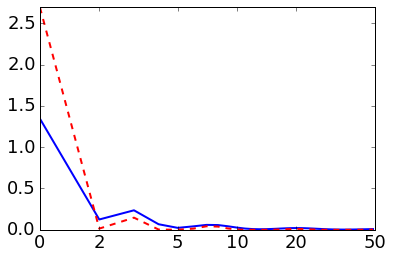

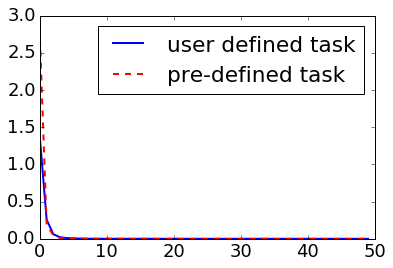

In [1294]:
LS = LogicalSession(UA)
# Print query count stats
LS.get_Q_stats()
# Plot density of queries
LS.density_query()



Time span: min: 1.66666666667e-05, max: 252.654083333
median: 0.215383333333, mean: 1.87235262092

Time span for search sessions: min: 3.33333333333e-05, max: 125.806066667
median: 0.321708333333, mean: 2.23556209573

Time span for no search sessions: min: 1.66666666667e-05, max: 252.654083333
median: 0.200583333333, mean: 1.79751297703


User tasks
Time span: min: 1.66666666667e-05, max: 116.404666667
median: 0.2322, mean: 1.79929526393

Time span for search sessions: min: 3.33333333333e-05, max: 116.404666667
median: 0.341733333333, mean: 2.31679987005

Time span for no search sessions: min: 1.66666666667e-05, max: 102.737983333
median: 0.209266666667, mean: 1.65834497832


Pre-defined tasks
Time span: min: 1.66666666667e-05, max: 252.654083333
median: 0.216733333333, mean: 2.29642399862

Time span for search sessions: min: 3.33333333333e-05, max: 125.806066667
median: 0.477983333333, mean: 3.18915836066

Time span for no search sessions: min: 1.66666666667e-05, max: 252.654083333
m

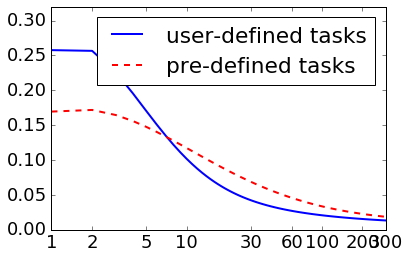

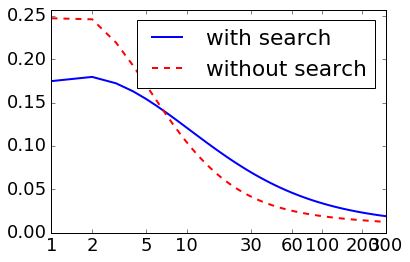

In [1295]:
LS = LogicalSession(UA)
LS.timespan_stats()
LS.timespan_density()


## Task sessions

1. Distribution of task length in #queries (Lucchess, Jones), median/mean (all 3)
2. Distribution of task length in time (Lucchess, Jones), median/mean (all 3)
3. Percentage of tasks without search
    * How does the length in terms of time compared to those with search? significant?
    * How does the level of interruptions compared to those with search? significant?
    * How do 0 query tasks distribute, in user defined and pre-defined tasks? significant?
4. Multi-tasking: 
    * Distribution of #tasks within a physical session (Lucchess)
    * Number of task returns (interruptions) - Hagen, Jones 

### Note
* None tasks were filtered out
* Logical sessions do not include events where users were not "on".

In [1296]:
# To store task information
def task_based_stats():
    Ts = []
    for userid, ua in UA: 
        # Get logical sessions
        L = logical_session(ua)
        # Filter None tasks
        L = [s for s in L if not s[0]['taskid'] == 'None']
    
        # logical session measures
        M = [{'taskid': l[0]['taskid'], 
          'q': number_queries(l),
          't': (l[-1]['timestamp_bson'] - l[0]['timestamp_bson']).total_seconds(),
          'start': l[0]['timestamp_bson'],
          'end': l[-1]['timestamp_bson'],
                } 
                 for l in L]
    
        # Group the sessions by tasks and aggregate counts
        M.sort(key=lambda x: x['taskid'])
        for taskid, g in itertools.groupby(M, lambda x: x['taskid']):
            g = list(g)
            num_q = sum([x['q'] for x in g])
            time = sum([x['t'] for x in g])/60
            # revisit
            revisit = (len(g)>1)
            # interrupt 
            interrupt = len(g) - 1
            # print taskid, q, t, revisit, interrupt
            # total span
            spread = (g[-1]['end'] - g[0]['start']).days + 1
            Ts.append({'taskid': taskid, 'q': num_q, 't': time, 'interrupt': interrupt, 
                   'revisit': revisit, 'days': spread, 'session_count': len(g)})
    return Ts

Ts = task_based_stats()

Ts_idx_search = [i for i in range(len(Ts)) if Ts[i]['q'] > 0]
Ts_idx_nosearch = [i for i in range(len(Ts)) if Ts[i]['q'] == 0]
Ts_idx_u = [i for i in range(len(Ts)) if not Ts[i]['taskid'] in to_exclude]
Ts_idx_o = [i for i in range(len(Ts)) if Ts[i]['taskid'] in pre_tasks]
Ts_idx_u_search = list(set(Ts_idx_u).intersection(set(Ts_idx_search)))
Ts_idx_u_nosearch = list(set(Ts_idx_u).intersection(set(Ts_idx_nosearch)))
Ts_idx_o_search = list(set(Ts_idx_o).intersection(set(Ts_idx_search)))
Ts_idx_o_nosearch = list(set(Ts_idx_o).intersection(set(Ts_idx_nosearch)))

# query number
Ts_Q = [t['q'] for t in Ts]
# time span
Ts_S = [t['t'] for t in Ts]
# revisit
Ts_R = [t['revisit'] for t in Ts]
# interrupt
Ts_I = [t['interrupt'] for t in Ts]
# Days
Ts_D = [t['days'] for t in Ts]
# session counts
Ts_SC = [t['session_count'] for t in Ts]

# Stats
# Number of user defined tasks registered in DB:
print "Total number of queries: %s"%(sum(Ts_Q))
tasks = list(db.user_tasks.find({'task_level': 0}))
print "Number of user defined tasks registered: %s"%len(tasks)
print "Number of user defined tasks logged: %s"%(len(Ts_idx_u))


Total number of queries: 2566
Number of user defined tasks registered: 305
Number of user defined tasks logged: 289


Number of queries in tasks:  min: 0, max: 120, median: 1.0, mean: 6.78835978836
Number of zero-query tasks:  155
Number of zero-query tasks (user-defined): 119
Number of zero-query tasks (predefined): 33


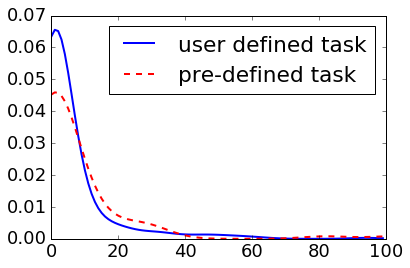

In [1297]:
# Stats of number of queries
print "Number of queries in tasks: ",
print "min: %s, max: %s, median: %s, mean: %s"%(min(Ts_Q), max(Ts_Q), np.median(Ts_Q), np.mean(Ts_Q))
# stats zero-queries
print "Number of zero-query tasks: ", len(Ts_idx_nosearch)
# stats zero-queries in user-defined vs. pre-define tasks
print "Number of zero-query tasks (user-defined):", len(Ts_idx_u_nosearch)
print "Number of zero-query tasks (predefined):", len(Ts_idx_o_nosearch)
# User defined tasks vs. pre-defined tasks query count Distribution
Ts_Q_u = [Ts_Q[i] for i in Ts_idx_u]
Ts_Q_o = [Ts_Q[i] for i in Ts_idx_o]
X = range(0, 100)
density_plot(Ts_Q_u, X, 'b-',  hold=False)
density_plot(Ts_Q_o, X, 'r--', hold=True)
pylab.legend(['user defined task', 'pre-defined task'])

Time span in tasks:  min: 3.33333333333e-05, max: 868.996616667, median: 10.4501833333, mean: 44.8225366843
Span over days:  min: 1, max: 10, median: 1.0, mean: 2.62698412698
% finished within one day:  0.505291005291
% span over the 5 day period: 0.216931216931

Timespan by user vs pre-defined tasks
User defined: min: 3.33333333333e-05, max: 612.0356, median: 9.25428333333, mean: 29.8409072664
Pre- defined: min: 0.0242833333333, max: 868.996616667, median: 29.690975, mean: 105.107947072

Timespan by search vs. nosearch tasks
User defined: min: 3.33333333333e-05, max: 868.996616667, median: 15.71265, mean: 57.9917886398
Pre- defined: min: 0.000366666666667, max: 637.92595, median: 3.93873333333, mean: 25.8758064516

Number of logical sessions by user vs pre-defined tasks:
User defined: min: 1, max: 263, median: 6.0, mean: 16.5847750865
Pre- defined: min: 1, max: 638, median: 19.0, mean: 45.7702702703


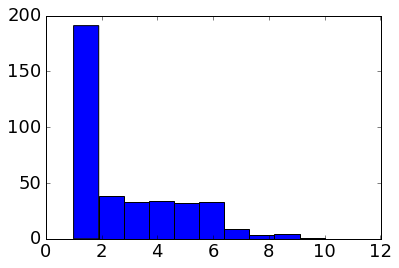

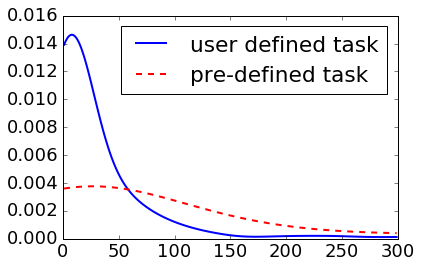

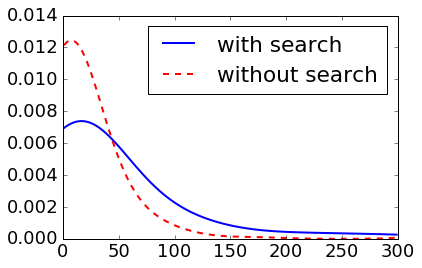

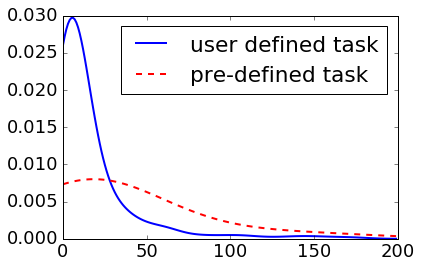

In [1298]:
# Stats of timestpan
print "Time span in tasks: ",
print "min: %s, max: %s, median: %s, mean: %s"%(min(Ts_S), max(Ts_S), np.median(Ts_S), np.mean(Ts_S))
print "Span over days: ", 
print "min: %s, max: %s, median: %s, mean: %s"%(min(Ts_D), max(Ts_D), np.median(Ts_D), np.mean(Ts_D))
print "% finished within one day: ", Ts_D.count(1)/float(len(Ts_D))
print "% span over the 5 day period:", len([d for d in Ts_D if d >=5])/float(len(Ts_D))
pylab.hist(Ts_D)


# User defined tasks vs. pre-defined tasks timespan Distribution
Ts_S_u = [Ts_S[i] for i in Ts_idx_u]
Ts_S_o = [Ts_S[i] for i in Ts_idx_o]
print
print 'Timespan by user vs pre-defined tasks'
print "User defined: min: %s, max: %s, median: %s, mean: %s"%(
    min(Ts_S_u), max(Ts_S_u), np.median(Ts_S_u), np.mean(Ts_S_u))
print "Pre- defined: min: %s, max: %s, median: %s, mean: %s"%(
    min(Ts_S_o), max(Ts_S_o), np.median(Ts_S_o), np.mean(Ts_S_o))

X = range(1, 300)
Xticks = [1, 2, 5, 10, 30, 60, 120, 300, 500]
density_plot(Ts_S_u, X, 'b-',  hold=False)
density_plot(Ts_S_o, X, 'r--', hold=True)
pylab.legend(['user defined task', 'pre-defined task'])


# With vs. without tasks
Ts_S_search = [Ts_S[i] for i in Ts_idx_search]
Ts_S_nosearch = [Ts_S[i] for i in Ts_idx_nosearch]

print
print 'Timespan by search vs. nosearch tasks'
print "User defined: min: %s, max: %s, median: %s, mean: %s"%(
    min(Ts_S_search), max(Ts_S_search), np.median(Ts_S_search), np.mean(Ts_S_search))
print "Pre- defined: min: %s, max: %s, median: %s, mean: %s"%(
    min(Ts_S_nosearch), max(Ts_S_nosearch), np.median(Ts_S_nosearch), np.mean(Ts_S_nosearch))

X = range(1, 300)
Xticks = [1, 2, 5, 10, 30, 60, 120, 300, 500]
density_plot(Ts_S_search, X, 'b-',  hold=False)
density_plot(Ts_S_nosearch, X, 'r--', hold=True)
pylab.legend(['with search', 'without search'])

# user defined task vs. pre-defined task, session span vs. session frequency
# overall time flipped here compared to the logical sessions
# user defined
print
print "Number of logical sessions by user vs pre-defined tasks:"
pylab.figure()
Ts_SC_u = [Ts_SC[i] for i in Ts_idx_u]
print "User defined: min: %s, max: %s, median: %s, mean: %s"%(
    min(Ts_SC_u), max(Ts_SC_u), np.median(Ts_SC_u), np.mean(Ts_SC_u))

print "Pre- defined: min: %s, max: %s, median: %s, mean: %s"%(
    min(Ts_SC_o), max(Ts_SC_o), np.median(Ts_SC_o), np.mean(Ts_SC_o))

Ts_SC_o = [Ts_SC[i] for i in Ts_idx_o]
X = range(0, 200)
Xticks = [1, 2, 5, 10, 20, 50, 100, 200]
density_plot(Ts_SC_u, X, 'b-', hold=False)
density_plot(Ts_SC_o, X, 'r--', hold=True)
pylab.legend(['user defined task', 'pre-defined task'])



In [1299]:
# Stats of interruptions
# Number of tasks returned (user vs. pre-defined tasks)
# Number of tasks returned (with vs. without search)
# Number of tasks returned (with vs. without search under user vs. pre-defined tasks)
    

    
    

## Sanity check
1. Number of user defined tasks inconsistant with previous count (291 vs. 289):
 - in logical session, we filtered out sessions that last for 0 seconds. This filters out 2 user defined tasks. 
2. Total number of queries unmatch with prevous count (2626 v. 2566) 
 - Difference because we now filtered out query events when user is not "on" the tab

In [1302]:
# Check number of user defined tasks
T_old = []
T_new = []
for userid, ua in UA:
    # exclude pre-defined tasks and None tasks
    data = filter_user_tasks(ua)
    T_old += [d['taskid'] for d, on in data]
    # Only include tasks where users were "on"
    T_new += [d['taskid'] for d, on in data if on]
print len(set(T_old)), len(set(T_new))

291 291


In [1303]:
# Check number of queries, previous count from data stream, i.e., events
q, q_u = 0, 0
q_new, q_u_new = 0, 0
for u in users:
    userid = u['userid']
    data = list(Labelled.find({'userid': u['userid']}))[0]['data']
    events = event_stream(data)
    ua = UserActivity.UserActivity(data, to_include, t_thresh, session_thresh)
    a_path, a_stream = ua.get_user_path()
    
    # Without filtering out the "not on" queries
    data = filter_tasks(a_stream)
    searches = filter_query_events(data)
    q += len(searches)
    searches_u = filter_user_tasks(searches)
    q_u += len(searches_u)
    
    searches = [s for s, on in searches if on]
    searches_u = [s for s, on in searches_u if on]
    q_new += len(searches)
    q_u_new += len(searches_u)

    
print "Old version:", q, q_u, "New version: ", q_new, q_u_new
print "difference:", q-q_new, q_u - q_u_new


Old version: 2626 1808 New version:  2566 1768
difference: 60 40
